# MNIST in TensorFlow Lite Micro

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Yawen

/content/gdrive/MyDrive/Yawen


In [ ]:
#!pip install tensorflow==2.2.0
!pip install tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-serv

# Python Modules

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten

# modules for plotting in this notebook
import numpy as np
import matplotlib.pyplot as plt
import random

Make sure we're on the right TensorFlow version

In [ ]:
tf.__version__

'2.12.0'

# Setup Training & Test Data to Model

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#cifar10 = tf.keras.datasets.cifar10
#(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
!ls

AMC+HAQ
checkpoint
data
DGMS
haq
HAWQ_test
main_early_exit_0.py
mnist_idx18.png
model_all.tflite
model_chunk1.cpp
model_chunk1.tflite
model_chunk2.cpp
model_chunk2.tflite
model_chunk3.cpp
model_chunk3.tflite
model.h5
model.pt
model_quant.tflite
openmv-catsvsdogs-classification
Pruning,_Incremental,_Entropy,_Split_Modes,_Mult_exit_MNIST_Digits_on_TensorFlow_Lite_for_Microcontrollers.ipynb
sine_model.h
sine_model.tflite
test.h5


In [ ]:
# load model arch with weights from file
#model = tf.keras.models.load_model("model.h5")
#model.summary()
#model.save_weights('weightsfile.h5')

In [ ]:
base_model1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=5, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
], name="base_model1")

exit1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=5, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
], name="exit1")

base_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
], name="base_model2")

exit2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding="same", activation='relu'),
    # tf.keras.layers.Conv2D(filters=20, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
], name="exit2")

base_model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
], name="base_model3")

image_input = tf.keras.layers.Input(shape=[28, 28], name="input")
# image_input = tf.keras.layers.Input(shape=[32, 32, 3])
z1 = base_model1(image_input)
out1 = exit1(z1)
z2 = base_model2(z1)
out2 = exit2(z2)
out3 = base_model3(z2)

model = tf.keras.Model(inputs=[image_input], outputs=[out1, out2, out3])

model.summary()

# Train the digit classification model
model.compile(optimizer='adam',
              loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)],
              loss_weights=[0.33,0.33,0.33],
              metrics=['accuracy'])
model.fit(
  train_images,
  [train_labels, train_labels, train_labels],
  batch_size=128,
  epochs=1,
  validation_data=(test_images, [test_labels, test_labels, test_labels])
)
# load weights only
# model.load_weights('weightsfile.h5')
#model.load_weights('pruned_weightsfile.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28)]     0           []                               
                                                                                                  
 base_model1 (Sequential)       (None, 14, 14, 5)    50          ['input[0][0]']                  
                                                                                                  
 base_model2 (Sequential)       (None, 7, 7, 10)     460         ['base_model1[0][0]']            
                                                                                                  
 exit1 (Sequential)             (None, 10)           2690        ['base_model1[0][0]']            
                                                                                              

In [ ]:
# model 1
split_base_model1 = tf.keras.Model(inputs=[image_input], outputs=[z1])#z1 = base_model1(image_input)
split_base_model1.summary()# split base_model1

# model 2
input_exit1 = tf.keras.layers.Input(shape=model.get_layer("exit1").input_shape[1:])
split_model_exit1 = tf.keras.Model(inputs=[input_exit1], outputs=[exit1(input_exit1)]) # out1 = exit1(z1)
split_model_exit1.summary()# split exit1

# model 3
input_base_model2 = tf.keras.layers.Input(shape=model.get_layer("base_model2").input_shape[1:]) # z1 = base_model1(image_input)
split_base_model2 = tf.keras.Model(inputs=[input_base_model2], outputs=[base_model2(input_base_model2)]) # z2 = base_model2(z1)
split_base_model2.summary() # split base_model2

# model 4
input_exit2 = tf.keras.layers.Input(shape=model.get_layer("exit2").input_shape[1:]) #  z1 = base_model1(image_input); z2 = base_model2(z1)
split_model_exit2 = tf.keras.Model(inputs=[input_exit2], outputs=[exit2(input_exit2)]) # out2 = exit2(z2)
split_model_exit2.summary() # split exit2

# model 5
input_base_model3 = tf.keras.layers.Input(shape=model.get_layer("base_model3").input_shape[1:])#z1 = base_model1(image_input); z2 = base_model2(z1);
split_base_model3 = tf.keras.Model(inputs=[input_base_model3], outputs=[base_model3(input_base_model3)])# out3 = base_model3(z2)
split_base_model3.summary()# split base_model3

model_pass1 = tf.keras.Model(inputs=[image_input], outputs=[split_model_exit1(split_base_model1(image_input))])
model_pass1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
#The input of model_pass1 is image input, after passing split_base_model1(base_model1) and split_model_exit1（exit1), we can get the output
model_pass2 = tf.keras.Model(inputs=[image_input], outputs=[split_model_exit2(split_base_model2(split_base_model1(image_input)))])
model_pass2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
#The input of model_pass2 is image_input, after passing base_model1, base_model2 and exit2, we can get outputs
model_pass3 = tf.keras.Model(inputs=[image_input], outputs=[split_base_model3(split_base_model2(split_base_model1(image_input)))])
model_pass3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
#The input of model_pass3 is image_input, after passing base_model1, base_model2, base_model3, we can get outputs
# model chunks
split_z1 = split_base_model1(image_input)#input: image_input, after base_model1, we can get split_z1
split_out1 = split_model_exit1(split_z1)#input: split_z1, after exit1, we can get split_out1, image_input after base_model, and exit1 is split_out1
split_z2 = split_base_model2(input_base_model2)
split_out2 = split_model_exit2(split_z2)
split_out3 = base_model3(input_base_model3)

# model_chunk1 = tf.keras.Model(inputs=[image_input], outputs=[split_model_exit1(split_base_model1(image_input)), split_base_model1(image_input)])
model_chunk1 = tf.keras.Model(inputs=[image_input], outputs=[split_out1, split_z1])
model_chunk1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

# model_chunk2 = tf.keras.Model(inputs=[input_base_model2], outputs=[split_model_exit2(split_base_model2(input_base_model2)), split_base_model2(input_base_model2)])
model_chunk2 = tf.keras.Model(inputs=[input_base_model2], outputs=[split_out2, split_z2])
model_chunk2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])#chunk2 provides two outputs split_out2, and split_z2

model_chunk3 = tf.keras.Model(inputs=[input_base_model3], outputs=[split_out3, split_out3])# chunk3 provides two outputs, split_out3 a
model_chunk3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 base_model1 (Sequential)    (None, 14, 14, 5)         50        
                                                                 
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 14, 5)]       0         
                                                                 
 exit1 (Sequential)          (None, 10)                2690      
                                                                 
Total params: 2,690
Trainable params: 2,690
No

In [ ]:
scores = model_pass1.evaluate(test_images, test_labels, verbose=2)
scores = model_pass2.evaluate(test_images, test_labels, verbose=2)
scores = model_pass3.evaluate(test_images, test_labels, verbose=2)

313/313 - 1s - loss: 0.3330 - accuracy: 0.9010 - 860ms/epoch - 3ms/step
313/313 - 1s - loss: 0.1927 - accuracy: 0.9424 - 1s/epoch - 4ms/step
313/313 - 1s - loss: 0.1287 - accuracy: 0.9582 - 1s/epoch - 4ms/step


# Evaluate and Save Model

In [ ]:
scores = model.evaluate(test_images, test_labels, verbose=2)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

# model.save("mnist.h5")

313/313 - 1s - loss: 0.2160 - exit1_loss: 0.3330 - exit2_loss: 0.1927 - base_model3_loss: 0.1287 - exit1_accuracy: 0.9010 - exit2_accuracy: 0.9424 - base_model3_accuracy: 0.9582 - 1s/epoch - 4ms/step
Test Loss: 0.21597988903522491
Test Accuracy: 0.33304381370544434


# Test Entropy Models

In [ ]:
import numpy as np
from scipy.stats import entropy

# Assuming softmax_output is the output from a softmax layer in your neural network
softmax_output = np.array([0.1, 0.2, 0.7])  # Example softmax output.

# Calculate the entropy
h = entropy(softmax_output, base=2)

print(h)  # Prints the entropy of the softmax output.


1.1567796494470395


In [ ]:
from tqdm import tqdm
import copy
from scipy.stats import entropy

# Helper function to run inference on a TFLite model
def run_models_entropy(models, test_image_indices, thresholds):
  global test_images

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  exits = np.zeros((len(test_image_indices),), dtype=int)
  entropies = np.zeros((len(test_image_indices),), dtype=float)
  for i, test_image_index in enumerate(tqdm(test_image_indices)):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    test_image = np.expand_dims(test_image, axis=0)

    exit_idx = 0
    for model_idx, model in enumerate(models):
      output, mid_feature = model.predict(test_image)
      output = tf.squeeze(output, 0)
      # print(output.shape)
      exit_idx = model_idx
      # normalized entropy: [0,1]
      uncertainty = entropy(output)/np.log(len(output))
      if uncertainty < thresholds[model_idx]:
        break
      test_image = mid_feature

    # print("output prob:", output, "entropy:", uncertainty)

    predictions[i] = tf.argmax(output)
    exits[i] = exit_idx
    entropies[i] = uncertainty

  return predictions, exits, entropies

In [ ]:
## Helper function to test the models on one image
def test_models_entropy(models, test_image_index, thresholds=(0.8, 0.7, 0.6)):
  global test_labels

  predictions, exits, entropies = run_models_entropy(models, [test_image_index], thresholds)

  plt.figure()
  plt.imshow(test_images[test_image_index])
  template = "Model \n True:{true}, Predicted:{predict}, Exit: {exit}, Entropy: {entropy:.4f}"
  _ = plt.title(template.format(true=str(test_labels[test_image_index]),
                                predict=str(predictions[0]), exit=exits[0], entropy=entropies[0]))
  plt.grid(False)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 139ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 99ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


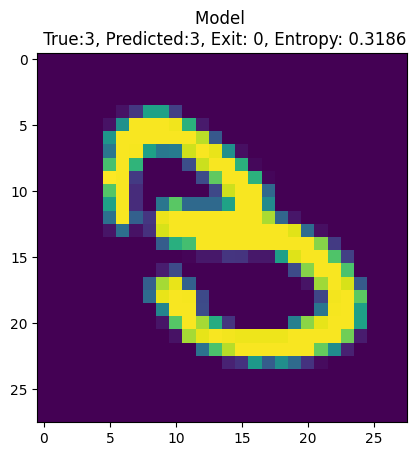

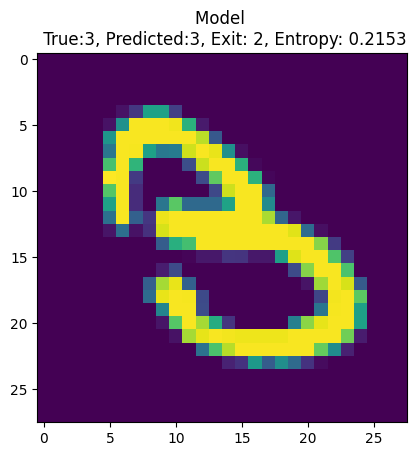

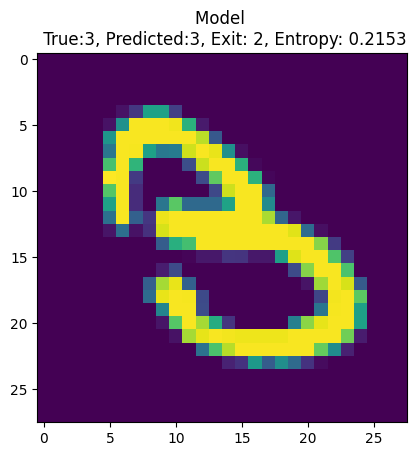

In [ ]:
# test_image_indices = range(test_images.shape[0])
test_image_indices = 18
# test_models_entropy([model_pass1, model_pass2, model_pass3], test_image_indices)
# test_models_entropy([model_chunk1, model_chunk2, model_chunk3], test_image_indices, thresholds=(0.1,0.08,0.02))
# test_models_entropy([model_chunk1, model_chunk2, model_chunk3], test_image_indices, thresholds=(0.09,0.08,0.02))
# test_models_entropy([model_chunk1, model_chunk2, model_chunk3], test_image_indices, thresholds=(0.09,0.06,0.02))
test_models_entropy([model_chunk1, model_chunk2, model_chunk3], test_image_indices, thresholds=(0.5,0.4,0.2))
test_models_entropy([model_chunk1, model_chunk2, model_chunk3], test_image_indices, thresholds=(0.0,0.4,0.2))
test_models_entropy([model_chunk1, model_chunk2, model_chunk3], test_image_indices, thresholds=(0.0,0.0,0.2))

In [ ]:
from PIL import Image as im
export_image = (test_images[test_image_indices]*255).astype(np.uint8)
print(export_image)
data = im.fromarray(export_image)
print(data)
data.save('mnist_idx18.png')
# list(data.getdata())

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  12  41 146 146  48   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  12 129 253 253 253 250 163  18   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 133 253 253 253 253 253 253 229  70   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 101 253 252 145 102 107 237 253 247 128  10   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 181 253 167   0   0   0  61 235 253 253 16

In [ ]:
print(data.size)

(28, 28)


In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_models_entropy(models, thresholds=(0.1,0.05,0.02)):
  global test_images
  global test_labels

  # test_image_indices = range(test_images.shape[0])
  test_image_indices = range(0,500)
  predictions, exits, entropies = run_models_entropy(models, test_image_indices, thresholds)

  test_image_labels = [test_labels[i] for i in test_image_indices]

  accuracy = (np.sum(test_image_labels== predictions) * 100) / len(test_image_indices)
  exit_num_selected = [0 for _ in range(max(exits)+1)]
  for exit in exits:
    exit_num_selected[exit] += 1

  print(f"entropy model accuracy is {accuracy:.4f}%, (Number of test samples={len(test_image_indices)})")
  # print(f"exits: {exits}")
  print(f"exit_num_selected: {exit_num_selected}")
  # print(f"entropies: {entropies}")
  print(f"avg entropy: {np.mean(entropies):6f}")

In [ ]:
# evaluate_models_entropy([model_pass1, model_pass2, model_pass3])
# evaluate_models_entropy([model_chunk1, model_chunk2, model_chunk3], thresholds=(0.05,0.02,0.01))
# evaluate_models_entropy([model_chunk1], thresholds=(0.1,0.05,0.02))
# evaluate_models_entropy([model_chunk1, model_chunk2], thresholds=(0.1,0.05,0.02))
# evaluate_models_entropy([model_chunk1, model_chunk2, model_chunk3], thresholds=(0.1,0.05,0.02))
evaluate_models_entropy([model_chunk1, model_chunk2, model_chunk3], thresholds=(0.5,0.4,0.2))

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/500 [00:00<00:30, 16.42it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/500 [00:00<00:27, 17.78it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 6/500 [00:00<00:27, 17.70it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 8/500 [00:00<00:26, 18.37it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 10/500 [00:00<00:31, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 12/500 [00:00<00:30, 16.04it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/500 [00:00<00:28, 16.80it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 16/500 [00:00<00:28, 16.85it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 18/500 [00:01<00:27, 17.49it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 20/500 [00:01<00:35, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 22/500 [00:01<00:32, 14.58it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 24/500 [00:01<00:30, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 26/500 [00:01<00:28, 16.52it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 28/500 [00:01<00:28, 16.54it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 30/500 [00:01<00:27, 16.93it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 32/500 [00:01<00:26, 17.40it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 34/500 [00:02<00:26, 17.88it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 36/500 [00:02<00:26, 17.64it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 38/500 [00:02<00:26, 17.66it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 40/500 [00:02<00:25, 17.77it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 42/500 [00:02<00:25, 18.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 44/500 [00:02<00:25, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 46/500 [00:02<00:25, 18.11it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 48/500 [00:02<00:25, 17.79it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 50/500 [00:02<00:24, 18.08it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 52/500 [00:03<00:25, 17.90it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 54/500 [00:03<00:25, 17.36it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 56/500 [00:03<00:26, 16.63it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 58/500 [00:03<00:26, 16.66it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 60/500 [00:03<00:26, 16.71it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 62/500 [00:03<00:26, 16.56it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 64/500 [00:03<00:32, 13.31it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 66/500 [00:04<00:37, 11.60it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 68/500 [00:04<00:40, 10.61it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 70/500 [00:04<00:35, 12.08it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 72/500 [00:04<00:31, 13.52it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 74/500 [00:04<00:36, 11.65it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 76/500 [00:04<00:32, 13.11it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 78/500 [00:05<00:29, 14.37it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 80/500 [00:05<00:27, 15.48it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 82/500 [00:05<00:26, 15.69it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 84/500 [00:05<00:25, 16.17it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 86/500 [00:05<00:25, 16.49it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 88/500 [00:05<00:24, 16.68it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 90/500 [00:05<00:24, 16.76it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 92/500 [00:05<00:27, 14.71it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 94/500 [00:06<00:39, 10.31it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 96/500 [00:06<00:37, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 98/500 [00:06<00:37, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 100/500 [00:06<00:35, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 102/500 [00:06<00:35, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 104/500 [00:07<00:34, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 106/500 [00:07<00:33, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 108/500 [00:07<00:33, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 110/500 [00:07<00:33, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 112/500 [00:07<00:33, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 114/500 [00:07<00:32, 11.84it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 116/500 [00:08<00:32, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 118/500 [00:08<00:32, 11.85it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 120/500 [00:08<00:41,  9.13it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 122/500 [00:08<00:38,  9.73it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 124/500 [00:08<00:36, 10.26it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 126/500 [00:09<00:34, 10.92it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 128/500 [00:09<00:29, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 130/500 [00:09<00:27, 13.68it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 132/500 [00:09<00:25, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 134/500 [00:09<00:24, 15.08it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 136/500 [00:09<00:22, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 138/500 [00:09<00:21, 16.64it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 140/500 [00:09<00:21, 16.63it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 142/500 [00:09<00:20, 17.17it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 144/500 [00:10<00:20, 17.33it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 146/500 [00:10<00:20, 17.17it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 148/500 [00:10<00:21, 16.76it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 150/500 [00:10<00:21, 16.55it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 152/500 [00:10<00:27, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 154/500 [00:10<00:25, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 156/500 [00:10<00:24, 13.84it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 158/500 [00:11<00:24, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 160/500 [00:11<00:22, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 162/500 [00:11<00:21, 15.72it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 164/500 [00:11<00:20, 16.14it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 166/500 [00:11<00:20, 16.30it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 168/500 [00:11<00:22, 14.55it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 170/500 [00:11<00:21, 15.31it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 172/500 [00:11<00:21, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 174/500 [00:12<00:20, 16.20it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 176/500 [00:12<00:19, 16.41it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 178/500 [00:12<00:18, 16.96it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 180/500 [00:12<00:18, 17.25it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 182/500 [00:12<00:19, 16.58it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 184/500 [00:12<00:19, 16.61it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 186/500 [00:12<00:18, 17.13it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 188/500 [00:12<00:17, 17.33it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 190/500 [00:13<00:18, 17.13it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 192/500 [00:13<00:17, 17.31it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 194/500 [00:13<00:23, 12.98it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 196/500 [00:13<00:28, 10.63it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 198/500 [00:13<00:27, 10.90it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 200/500 [00:13<00:25, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 202/500 [00:14<00:24, 12.21it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 204/500 [00:14<00:23, 12.59it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 206/500 [00:14<00:23, 12.40it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 208/500 [00:14<00:23, 12.35it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 210/500 [00:14<00:23, 12.27it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 212/500 [00:14<00:23, 12.34it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 214/500 [00:15<00:24, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 216/500 [00:15<00:23, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 218/500 [00:15<00:23, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 220/500 [00:15<00:23, 11.69it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 222/500 [00:15<00:23, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 224/500 [00:15<00:23, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 226/500 [00:16<00:23, 11.73it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 228/500 [00:16<00:22, 12.02it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 230/500 [00:16<00:21, 12.45it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 232/500 [00:16<00:21, 12.47it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 234/500 [00:16<00:21, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 236/500 [00:16<00:21, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 238/500 [00:17<00:19, 13.34it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 240/500 [00:17<00:18, 14.32it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 242/500 [00:17<00:21, 12.05it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 244/500 [00:17<00:19, 13.36it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 246/500 [00:17<00:17, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 248/500 [00:17<00:16, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 250/500 [00:17<00:16, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 252/500 [00:17<00:16, 15.50it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 254/500 [00:18<00:15, 16.12it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 256/500 [00:18<00:14, 16.66it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 258/500 [00:18<00:16, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 260/500 [00:18<00:15, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 262/500 [00:18<00:18, 12.70it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 264/500 [00:18<00:17, 13.52it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 266/500 [00:19<00:20, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 268/500 [00:19<00:19, 11.62it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 270/500 [00:19<00:20, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 272/500 [00:19<00:19, 11.84it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 274/500 [00:19<00:18, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 276/500 [00:19<00:18, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 278/500 [00:20<00:18, 12.12it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 280/500 [00:20<00:17, 12.23it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 282/500 [00:20<00:17, 12.20it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 284/500 [00:20<00:23,  9.33it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 286/500 [00:20<00:21,  9.85it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 288/500 [00:21<00:20, 10.18it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 290/500 [00:21<00:19, 10.73it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 292/500 [00:21<00:23,  8.88it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 294/500 [00:21<00:21,  9.57it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 296/500 [00:21<00:20, 10.18it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 298/500 [00:22<00:19, 10.47it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 300/500 [00:22<00:18, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 302/500 [00:22<00:17, 11.10it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 304/500 [00:22<00:17, 11.48it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 306/500 [00:22<00:15, 12.74it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 308/500 [00:22<00:13, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 310/500 [00:22<00:12, 14.92it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 312/500 [00:23<00:12, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 314/500 [00:23<00:11, 16.01it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 316/500 [00:23<00:11, 16.28it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 318/500 [00:23<00:10, 16.61it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 320/500 [00:23<00:10, 16.84it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 322/500 [00:23<00:10, 17.22it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 324/500 [00:23<00:10, 17.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 326/500 [00:23<00:11, 15.38it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 328/500 [00:24<00:10, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 330/500 [00:24<00:11, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 332/500 [00:24<00:10, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 334/500 [00:24<00:10, 15.68it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 336/500 [00:24<00:09, 16.42it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 338/500 [00:24<00:10, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 340/500 [00:24<00:09, 16.18it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 342/500 [00:25<00:14, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 344/500 [00:25<00:12, 12.01it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 346/500 [00:25<00:11, 13.14it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 348/500 [00:25<00:10, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 350/500 [00:25<00:09, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 352/500 [00:25<00:09, 15.52it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 354/500 [00:25<00:09, 16.14it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 356/500 [00:25<00:08, 16.34it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 358/500 [00:26<00:08, 16.60it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 360/500 [00:26<00:11, 12.59it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 362/500 [00:26<00:10, 13.56it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 364/500 [00:26<00:09, 14.24it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 366/500 [00:26<00:08, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 368/500 [00:26<00:08, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 370/500 [00:26<00:08, 16.01it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 372/500 [00:26<00:07, 16.58it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 374/500 [00:27<00:07, 17.03it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 376/500 [00:27<00:07, 16.82it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 378/500 [00:27<00:07, 16.69it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 380/500 [00:27<00:07, 17.01it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 382/500 [00:27<00:06, 17.06it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 384/500 [00:27<00:06, 16.96it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 386/500 [00:27<00:06, 17.02it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 388/500 [00:27<00:06, 17.25it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 390/500 [00:28<00:06, 17.60it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 392/500 [00:28<00:06, 17.51it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 394/500 [00:28<00:06, 17.02it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 396/500 [00:28<00:06, 17.11it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 398/500 [00:28<00:06, 16.70it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 400/500 [00:28<00:06, 16.58it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 402/500 [00:28<00:05, 16.87it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 404/500 [00:28<00:07, 13.00it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 406/500 [00:29<00:06, 13.79it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 408/500 [00:29<00:06, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 410/500 [00:29<00:06, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 412/500 [00:29<00:05, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 414/500 [00:29<00:05, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 416/500 [00:29<00:05, 16.24it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 418/500 [00:29<00:04, 16.75it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 420/500 [00:29<00:04, 16.40it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 422/500 [00:30<00:04, 16.63it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 424/500 [00:30<00:04, 16.35it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 426/500 [00:30<00:04, 16.53it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 428/500 [00:30<00:04, 16.40it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 430/500 [00:30<00:04, 16.71it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 432/500 [00:30<00:04, 16.48it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 434/500 [00:30<00:04, 16.25it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 436/500 [00:30<00:03, 16.57it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 438/500 [00:31<00:03, 16.60it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 440/500 [00:31<00:03, 16.59it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 442/500 [00:31<00:03, 16.89it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 444/500 [00:31<00:03, 17.50it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 446/500 [00:31<00:03, 17.01it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 448/500 [00:31<00:03, 17.19it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 450/500 [00:31<00:02, 17.57it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 452/500 [00:31<00:02, 17.65it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 454/500 [00:31<00:02, 17.73it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 456/500 [00:32<00:02, 17.30it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 458/500 [00:32<00:02, 17.30it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 460/500 [00:32<00:02, 17.13it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 462/500 [00:32<00:02, 17.15it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 464/500 [00:32<00:02, 16.76it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 466/500 [00:32<00:02, 14.87it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 468/500 [00:32<00:02, 14.20it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 470/500 [00:33<00:02, 10.45it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 472/500 [00:33<00:02, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 474/500 [00:33<00:02, 11.84it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 476/500 [00:33<00:02, 11.93it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 478/500 [00:33<00:01, 12.40it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 480/500 [00:34<00:02,  9.64it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 482/500 [00:34<00:01, 10.48it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 484/500 [00:34<00:01, 10.63it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 486/500 [00:34<00:01, 10.99it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 488/500 [00:34<00:01, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 490/500 [00:34<00:00, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 492/500 [00:35<00:00, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 494/500 [00:35<00:00, 12.55it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 496/500 [00:35<00:00,  9.68it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 498/500 [00:35<00:00,  8.06it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 500/500 [00:36<00:00, 13.87it/s]

entropy model accuracy is 92.2000%, (Number of test samples=500)
exit_num_selected: [473, 5, 22]
avg entropy: 0.128738


In [ ]:
evaluate_models_entropy([model_chunk1, model_chunk2, model_chunk3], thresholds=(1.0,1.0,1.0))
evaluate_models_entropy([model_chunk1, model_chunk2, model_chunk3], thresholds=(-1.0,1.0,1.0))
evaluate_models_entropy([model_chunk1, model_chunk2, model_chunk3], thresholds=(-1.0,-1.0,1.0))

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/500 [00:00<00:41, 12.14it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 4/500 [00:00<00:43, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 6/500 [00:00<00:42, 11.74it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 8/500 [00:00<00:41, 11.72it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 10/500 [00:00<00:41, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 12/500 [00:01<00:41, 11.88it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 14/500 [00:01<00:39, 12.29it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 16/500 [00:01<00:39, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 18/500 [00:01<00:39, 12.11it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 20/500 [00:01<00:40, 11.87it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 22/500 [00:01<00:40, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 24/500 [00:02<00:39, 11.95it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 26/500 [00:02<00:37, 12.61it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 28/500 [00:02<00:33, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 30/500 [00:02<00:31, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 32/500 [00:02<00:30, 15.20it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 34/500 [00:02<00:30, 15.34it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 36/500 [00:02<00:29, 15.81it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 38/500 [00:02<00:28, 16.34it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 40/500 [00:02<00:28, 16.27it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 42/500 [00:03<00:27, 16.82it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 44/500 [00:03<00:28, 16.29it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 46/500 [00:03<00:27, 16.57it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 48/500 [00:03<00:26, 16.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 50/500 [00:03<00:25, 17.36it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 52/500 [00:03<00:26, 16.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 54/500 [00:03<00:25, 17.17it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 56/500 [00:03<00:26, 16.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 58/500 [00:04<00:25, 17.05it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 60/500 [00:04<00:25, 17.19it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 62/500 [00:04<00:26, 16.68it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 64/500 [00:04<00:26, 16.61it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 66/500 [00:04<00:25, 16.88it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 68/500 [00:04<00:25, 17.03it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 70/500 [00:04<00:26, 16.23it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 72/500 [00:04<00:27, 15.76it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 74/500 [00:05<00:27, 15.77it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 76/500 [00:05<00:25, 16.55it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 78/500 [00:05<00:25, 16.50it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 80/500 [00:05<00:25, 16.44it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 82/500 [00:05<00:24, 17.05it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 84/500 [00:05<00:24, 16.70it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 86/500 [00:05<00:24, 17.06it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 88/500 [00:05<00:25, 15.99it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 90/500 [00:05<00:25, 15.93it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 92/500 [00:06<00:24, 16.33it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 94/500 [00:06<00:24, 16.79it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 96/500 [00:06<00:23, 16.94it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 98/500 [00:06<00:24, 16.45it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 100/500 [00:06<00:25, 15.86it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 102/500 [00:06<00:24, 16.30it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 104/500 [00:06<00:23, 16.69it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 106/500 [00:06<00:23, 16.57it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 108/500 [00:07<00:24, 16.15it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 110/500 [00:07<00:23, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 112/500 [00:07<00:23, 16.73it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 114/500 [00:07<00:23, 16.23it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 116/500 [00:07<00:23, 16.16it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 118/500 [00:07<00:22, 16.79it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 120/500 [00:07<00:22, 16.92it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 122/500 [00:07<00:22, 17.05it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 124/500 [00:08<00:22, 16.50it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 126/500 [00:08<00:22, 16.87it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 128/500 [00:08<00:22, 16.90it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 130/500 [00:08<00:21, 17.36it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 132/500 [00:08<00:20, 17.53it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 134/500 [00:08<00:21, 16.76it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 136/500 [00:08<00:21, 16.86it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 138/500 [00:08<00:21, 16.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 140/500 [00:08<00:21, 16.83it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 142/500 [00:09<00:22, 15.79it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 144/500 [00:09<00:22, 15.82it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 146/500 [00:09<00:21, 16.34it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 148/500 [00:09<00:21, 16.56it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 150/500 [00:09<00:21, 16.57it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 152/500 [00:09<00:20, 16.73it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 154/500 [00:09<00:20, 17.28it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 156/500 [00:09<00:19, 17.77it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 158/500 [00:10<00:20, 17.02it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 160/500 [00:10<00:19, 17.06it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 162/500 [00:10<00:20, 16.48it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 164/500 [00:10<00:20, 16.68it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 166/500 [00:10<00:19, 16.92it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 168/500 [00:10<00:19, 16.74it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 170/500 [00:10<00:20, 16.17it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 172/500 [00:10<00:19, 16.46it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 174/500 [00:11<00:19, 16.86it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 176/500 [00:11<00:19, 16.73it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 178/500 [00:11<00:19, 16.39it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 180/500 [00:11<00:19, 16.66it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 182/500 [00:11<00:19, 16.73it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 184/500 [00:11<00:18, 16.69it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 186/500 [00:11<00:19, 16.10it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 188/500 [00:11<00:18, 16.44it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 190/500 [00:11<00:18, 16.35it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 192/500 [00:12<00:20, 15.11it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 194/500 [00:12<00:21, 14.36it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 196/500 [00:12<00:22, 13.41it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 198/500 [00:12<00:23, 12.66it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 200/500 [00:12<00:24, 12.49it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 202/500 [00:12<00:24, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 204/500 [00:13<00:24, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 206/500 [00:13<00:24, 11.88it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 208/500 [00:13<00:24, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 210/500 [00:13<00:24, 11.68it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 212/500 [00:13<00:24, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 214/500 [00:14<00:25, 11.37it/s]

1/1 [==============================] - 0s 92ms/step


 43%|████▎     | 216/500 [00:14<00:29,  9.58it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▎     | 218/500 [00:14<00:34,  8.21it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 219/500 [00:14<00:36,  7.64it/s]

1/1 [==============================] - 0s 91ms/step


 44%|████▍     | 220/500 [00:15<00:40,  6.97it/s]

1/1 [==============================] - 0s 86ms/step


 44%|████▍     | 221/500 [00:15<00:44,  6.28it/s]

1/1 [==============================] - 0s 189ms/step


 44%|████▍     | 222/500 [00:15<00:55,  5.02it/s]

1/1 [==============================] - 0s 161ms/step


 45%|████▍     | 223/500 [00:15<01:09,  3.97it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 224/500 [00:16<01:01,  4.50it/s]

1/1 [==============================] - 0s 130ms/step


 45%|████▌     | 225/500 [00:16<01:02,  4.42it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 226/500 [00:16<00:53,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 227/500 [00:16<00:50,  5.43it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 228/500 [00:16<00:43,  6.26it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 229/500 [00:16<00:39,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 230/500 [00:16<00:39,  6.89it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 231/500 [00:17<00:42,  6.26it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▋     | 232/500 [00:17<00:40,  6.67it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 234/500 [00:17<00:33,  7.88it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 236/500 [00:17<00:31,  8.39it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 237/500 [00:17<00:32,  8.03it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 239/500 [00:18<00:29,  8.79it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 240/500 [00:18<00:30,  8.63it/s]

1/1 [==============================] - 0s 77ms/step


 48%|████▊     | 241/500 [00:18<00:32,  7.89it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 242/500 [00:18<00:34,  7.56it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 243/500 [00:18<00:33,  7.76it/s]

1/1 [==============================] - 0s 70ms/step


 49%|████▉     | 244/500 [00:18<00:33,  7.64it/s]

1/1 [==============================] - 0s 100ms/step


 49%|████▉     | 245/500 [00:18<00:37,  6.72it/s]

1/1 [==============================] - 0s 74ms/step


 49%|████▉     | 246/500 [00:19<00:41,  6.11it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 247/500 [00:19<00:38,  6.61it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 248/500 [00:19<00:36,  6.95it/s]

1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 249/500 [00:19<00:38,  6.49it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 250/500 [00:19<00:35,  6.97it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 252/500 [00:19<00:29,  8.39it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 253/500 [00:19<00:29,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 254/500 [00:20<00:31,  7.85it/s]

1/1 [==============================] - 0s 97ms/step


 51%|█████     | 255/500 [00:20<00:37,  6.55it/s]

1/1 [==============================] - 0s 79ms/step


 51%|█████     | 256/500 [00:20<00:41,  5.81it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 257/500 [00:20<00:39,  6.18it/s]

1/1 [==============================] - 0s 71ms/step


 52%|█████▏    | 258/500 [00:20<00:45,  5.28it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 259/500 [00:21<00:43,  5.51it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 260/500 [00:21<00:40,  5.90it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 261/500 [00:21<00:39,  6.11it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 262/500 [00:21<00:37,  6.43it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 263/500 [00:21<00:35,  6.72it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 264/500 [00:21<00:31,  7.39it/s]

1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 266/500 [00:22<00:32,  7.20it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 267/500 [00:22<00:31,  7.30it/s]

1/1 [==============================] - 0s 90ms/step


 54%|█████▎    | 268/500 [00:22<00:35,  6.48it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 269/500 [00:22<00:37,  6.18it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 270/500 [00:22<00:36,  6.35it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 272/500 [00:22<00:29,  7.62it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 273/500 [00:23<00:28,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 274/500 [00:23<00:27,  8.29it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 276/500 [00:23<00:26,  8.46it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 277/500 [00:23<00:25,  8.68it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 279/500 [00:23<00:23,  9.44it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 280/500 [00:23<00:24,  8.81it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 281/500 [00:23<00:26,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 282/500 [00:24<00:25,  8.40it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 284/500 [00:24<00:20, 10.46it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 286/500 [00:24<00:17, 12.01it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 288/500 [00:24<00:15, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 290/500 [00:24<00:15, 13.85it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 292/500 [00:24<00:14, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 294/500 [00:24<00:13, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 296/500 [00:24<00:13, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 298/500 [00:25<00:13, 15.41it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 300/500 [00:25<00:12, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 302/500 [00:25<00:12, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 304/500 [00:25<00:12, 15.99it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 306/500 [00:25<00:12, 15.83it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 308/500 [00:25<00:12, 16.00it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 310/500 [00:25<00:11, 16.25it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 312/500 [00:25<00:11, 16.28it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 314/500 [00:26<00:13, 14.20it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 316/500 [00:26<00:13, 13.18it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 318/500 [00:26<00:13, 13.24it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 320/500 [00:26<00:14, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 322/500 [00:26<00:14, 12.17it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 324/500 [00:26<00:14, 12.27it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 326/500 [00:27<00:14, 12.43it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 328/500 [00:27<00:13, 12.36it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 330/500 [00:27<00:13, 12.20it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 332/500 [00:27<00:14, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 334/500 [00:27<00:14, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 336/500 [00:27<00:14, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 338/500 [00:28<00:14, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 340/500 [00:28<00:13, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 342/500 [00:28<00:13, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 344/500 [00:28<00:13, 11.72it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 346/500 [00:28<00:13, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 348/500 [00:29<00:13, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 350/500 [00:29<00:13, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 352/500 [00:29<00:13, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 354/500 [00:29<00:13, 10.81it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 356/500 [00:29<00:12, 11.13it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 358/500 [00:29<00:11, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 360/500 [00:30<00:10, 13.28it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 362/500 [00:30<00:10, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 364/500 [00:30<00:09, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 366/500 [00:30<00:09, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 368/500 [00:30<00:08, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 370/500 [00:30<00:08, 15.90it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 372/500 [00:30<00:08, 15.91it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 374/500 [00:30<00:07, 16.15it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 376/500 [00:31<00:07, 16.30it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 378/500 [00:31<00:07, 16.70it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 380/500 [00:31<00:07, 16.72it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 382/500 [00:31<00:07, 16.67it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 384/500 [00:31<00:07, 16.40it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 386/500 [00:31<00:07, 16.15it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 388/500 [00:31<00:07, 15.98it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 390/500 [00:31<00:06, 16.16it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 392/500 [00:31<00:06, 15.87it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 394/500 [00:32<00:06, 15.71it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 396/500 [00:32<00:06, 16.00it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 398/500 [00:32<00:06, 16.40it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 400/500 [00:32<00:06, 16.61it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 402/500 [00:32<00:06, 15.67it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 404/500 [00:32<00:06, 15.72it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 406/500 [00:32<00:05, 16.20it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 408/500 [00:32<00:05, 16.49it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 410/500 [00:33<00:05, 16.14it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 412/500 [00:33<00:05, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 414/500 [00:33<00:05, 16.26it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 416/500 [00:33<00:05, 16.37it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 418/500 [00:33<00:05, 16.29it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 420/500 [00:33<00:05, 15.92it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 422/500 [00:33<00:04, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 424/500 [00:33<00:04, 16.15it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 426/500 [00:34<00:04, 16.04it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 428/500 [00:34<00:04, 15.52it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 430/500 [00:34<00:04, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 432/500 [00:34<00:04, 15.86it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 434/500 [00:34<00:04, 15.92it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 436/500 [00:34<00:03, 16.01it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 438/500 [00:34<00:03, 15.67it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 440/500 [00:34<00:03, 15.99it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 442/500 [00:35<00:03, 15.70it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 444/500 [00:35<00:03, 16.11it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 446/500 [00:35<00:03, 15.96it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 448/500 [00:35<00:03, 15.72it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 450/500 [00:35<00:03, 15.37it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 452/500 [00:35<00:03, 15.63it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 454/500 [00:35<00:02, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 456/500 [00:36<00:02, 15.37it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 458/500 [00:36<00:02, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 460/500 [00:36<00:02, 15.67it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 462/500 [00:36<00:02, 15.73it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 464/500 [00:36<00:02, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 466/500 [00:36<00:02, 15.70it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 468/500 [00:36<00:01, 16.21it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 470/500 [00:36<00:01, 15.92it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 472/500 [00:37<00:01, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 474/500 [00:37<00:02,  9.36it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 476/500 [00:37<00:02, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 478/500 [00:37<00:01, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 480/500 [00:37<00:01, 12.08it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 482/500 [00:38<00:01, 12.35it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 484/500 [00:38<00:01, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 486/500 [00:38<00:01, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 488/500 [00:38<00:00, 13.39it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 490/500 [00:38<00:00, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 492/500 [00:38<00:00, 12.95it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 494/500 [00:38<00:00, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 496/500 [00:39<00:00, 13.71it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 498/500 [00:39<00:00, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 500/500 [00:39<00:00, 12.71it/s]


entropy model accuracy is 93.0000%, (Number of test samples=500)
exit_num_selected: [500]
avg entropy: 0.145537


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 1/500 [00:00<01:17,  6.48it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 2/500 [00:00<01:14,  6.64it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 3/500 [00:00<01:22,  6.06it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 4/500 [00:00<01:30,  5.46it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 5/500 [00:00<01:31,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 6/500 [00:01<01:32,  5.32it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 7/500 [00:01<01:31,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 8/500 [00:01<01:31,  5.39it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 9/500 [00:01<01:32,  5.32it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 10/500 [00:01<01:31,  5.35it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 11/500 [00:02<01:32,  5.26it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 12/500 [00:02<01:32,  5.29it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 13/500 [00:02<01:34,  5.17it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 14/500 [00:02<01:34,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 15/500 [00:02<01:34,  5.14it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 16/500 [00:02<01:34,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 17/500 [00:03<01:33,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 18/500 [00:03<01:32,  5.23it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 19/500 [00:03<01:28,  5.41it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 20/500 [00:03<01:28,  5.43it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 21/500 [00:03<01:28,  5.42it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 22/500 [00:04<01:32,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 23/500 [00:04<01:24,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 24/500 [00:04<01:17,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 25/500 [00:04<01:12,  6.57it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 26/500 [00:04<01:09,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 27/500 [00:04<01:09,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 28/500 [00:04<01:08,  6.91it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 29/500 [00:05<01:06,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 30/500 [00:05<01:05,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 31/500 [00:05<01:05,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 32/500 [00:05<01:03,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 33/500 [00:05<01:02,  7.53it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 34/500 [00:05<01:01,  7.53it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 35/500 [00:05<01:02,  7.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 36/500 [00:05<01:01,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 37/500 [00:06<00:59,  7.75it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 38/500 [00:06<01:00,  7.68it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 39/500 [00:06<00:59,  7.71it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 40/500 [00:06<01:00,  7.64it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 41/500 [00:06<01:00,  7.60it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 42/500 [00:06<01:02,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 43/500 [00:06<01:00,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 44/500 [00:07<00:59,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 45/500 [00:07<01:00,  7.57it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 46/500 [00:07<00:58,  7.75it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 47/500 [00:07<00:59,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 48/500 [00:07<00:57,  7.81it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 49/500 [00:07<00:59,  7.64it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 50/500 [00:07<00:59,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 51/500 [00:07<00:59,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 52/500 [00:08<00:57,  7.77it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 53/500 [00:08<00:57,  7.78it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 54/500 [00:08<00:58,  7.63it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 55/500 [00:08<00:58,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 56/500 [00:08<00:56,  7.83it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 57/500 [00:08<00:57,  7.75it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 58/500 [00:08<00:58,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 59/500 [00:09<00:58,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 60/500 [00:09<00:57,  7.70it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 61/500 [00:09<00:58,  7.55it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 62/500 [00:09<00:58,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 63/500 [00:09<00:57,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 64/500 [00:09<00:55,  7.79it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 65/500 [00:09<00:55,  7.87it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 66/500 [00:09<00:58,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 67/500 [00:10<00:57,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 68/500 [00:10<00:56,  7.66it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 69/500 [00:10<00:54,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 70/500 [00:10<00:55,  7.79it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 71/500 [00:10<00:54,  7.86it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 72/500 [00:10<00:54,  7.84it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 73/500 [00:10<00:54,  7.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 74/500 [00:10<00:56,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 75/500 [00:11<00:55,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 76/500 [00:11<00:55,  7.61it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 77/500 [00:11<00:56,  7.50it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 78/500 [00:11<00:56,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 79/500 [00:11<00:56,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 80/500 [00:11<00:56,  7.46it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 81/500 [00:11<00:56,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 82/500 [00:12<00:55,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 83/500 [00:12<00:54,  7.72it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 84/500 [00:12<00:54,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 85/500 [00:12<00:53,  7.69it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 86/500 [00:12<00:52,  7.85it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 87/500 [00:12<00:52,  7.89it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 88/500 [00:12<00:53,  7.77it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 89/500 [00:12<00:53,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 90/500 [00:13<00:52,  7.80it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 91/500 [00:13<00:52,  7.81it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 92/500 [00:13<00:53,  7.62it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 93/500 [00:13<00:52,  7.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 94/500 [00:13<00:51,  7.81it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 95/500 [00:13<00:51,  7.82it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 96/500 [00:13<00:52,  7.75it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 97/500 [00:13<00:53,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 98/500 [00:14<00:52,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 99/500 [00:14<00:57,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 100/500 [00:14<00:59,  6.69it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 101/500 [00:14<01:02,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 102/500 [00:14<01:04,  6.21it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 103/500 [00:14<01:06,  5.93it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 104/500 [00:15<01:10,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 105/500 [00:15<01:12,  5.48it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 106/500 [00:15<01:12,  5.40it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 107/500 [00:15<01:10,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 108/500 [00:15<01:09,  5.65it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 109/500 [00:16<01:09,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 110/500 [00:16<01:06,  5.84it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 111/500 [00:16<01:08,  5.64it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 112/500 [00:16<01:08,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 113/500 [00:16<01:08,  5.69it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 114/500 [00:16<01:07,  5.70it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 115/500 [00:17<01:10,  5.45it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 116/500 [00:17<01:07,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 117/500 [00:17<01:09,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 118/500 [00:17<01:07,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 119/500 [00:17<01:07,  5.63it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 120/500 [00:18<01:11,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 121/500 [00:18<01:08,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 122/500 [00:18<01:03,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 123/500 [00:18<00:59,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 124/500 [00:18<00:56,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 125/500 [00:18<00:54,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 126/500 [00:18<00:52,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 127/500 [00:19<00:51,  7.20it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 128/500 [00:19<00:49,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 129/500 [00:19<00:50,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 130/500 [00:19<00:48,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 131/500 [00:19<00:47,  7.75it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 132/500 [00:19<00:47,  7.72it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 133/500 [00:19<00:48,  7.58it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 134/500 [00:19<00:48,  7.54it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 135/500 [00:20<00:46,  7.77it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 136/500 [00:20<00:48,  7.57it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 137/500 [00:20<00:46,  7.75it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 138/500 [00:20<00:47,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 139/500 [00:20<00:45,  7.87it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 140/500 [00:20<00:46,  7.82it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 141/500 [00:20<00:45,  7.92it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 142/500 [00:20<00:45,  7.80it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 143/500 [00:21<00:45,  7.81it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 144/500 [00:21<00:47,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 145/500 [00:21<00:47,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 146/500 [00:21<00:48,  7.33it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 147/500 [00:21<00:48,  7.32it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 148/500 [00:21<00:46,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 149/500 [00:21<00:46,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 150/500 [00:22<00:45,  7.63it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 151/500 [00:22<00:47,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 152/500 [00:22<00:47,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 153/500 [00:22<00:46,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 154/500 [00:22<00:44,  7.73it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 155/500 [00:22<00:44,  7.80it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 156/500 [00:22<00:44,  7.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 157/500 [00:22<00:44,  7.66it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 158/500 [00:23<00:44,  7.69it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 159/500 [00:23<00:43,  7.83it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 160/500 [00:23<00:45,  7.49it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 161/500 [00:23<00:45,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 162/500 [00:23<00:45,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 163/500 [00:23<00:44,  7.55it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 164/500 [00:23<00:43,  7.64it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 165/500 [00:23<00:43,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 166/500 [00:24<00:43,  7.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 167/500 [00:24<00:43,  7.71it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 168/500 [00:24<00:44,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 169/500 [00:24<00:45,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 170/500 [00:24<00:43,  7.57it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 171/500 [00:24<00:43,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 172/500 [00:24<00:43,  7.46it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 173/500 [00:25<00:43,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 174/500 [00:25<00:43,  7.56it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 175/500 [00:25<00:44,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 176/500 [00:25<00:43,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 177/500 [00:25<00:43,  7.39it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 178/500 [00:25<00:44,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 179/500 [00:25<00:44,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 180/500 [00:26<00:43,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 181/500 [00:26<00:43,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 182/500 [00:26<00:43,  7.23it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 183/500 [00:26<00:44,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 184/500 [00:26<00:43,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 185/500 [00:26<00:42,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 186/500 [00:26<00:41,  7.53it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 187/500 [00:26<00:42,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 188/500 [00:27<00:41,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 189/500 [00:27<00:40,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 190/500 [00:27<00:40,  7.68it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 191/500 [00:27<00:40,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 192/500 [00:27<00:40,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 193/500 [00:27<00:40,  7.63it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 194/500 [00:27<00:40,  7.57it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 195/500 [00:28<00:41,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 196/500 [00:28<00:40,  7.49it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 197/500 [00:28<00:46,  6.51it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 198/500 [00:28<00:48,  6.22it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 199/500 [00:28<00:48,  6.15it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 200/500 [00:28<00:51,  5.82it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 201/500 [00:29<00:50,  5.88it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 202/500 [00:29<00:50,  5.91it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 203/500 [00:29<00:51,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 204/500 [00:29<00:52,  5.59it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 205/500 [00:29<00:52,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 206/500 [00:29<00:51,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 207/500 [00:30<00:51,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 208/500 [00:30<00:51,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 209/500 [00:30<00:54,  5.37it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 210/500 [00:30<00:52,  5.56it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 211/500 [00:30<00:52,  5.50it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 212/500 [00:31<00:51,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 213/500 [00:31<00:50,  5.72it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 214/500 [00:31<00:49,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 215/500 [00:31<00:51,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 216/500 [00:31<00:52,  5.46it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 217/500 [00:31<00:52,  5.43it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 218/500 [00:32<00:52,  5.38it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 219/500 [00:32<00:52,  5.32it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 220/500 [00:32<00:52,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 221/500 [00:32<00:48,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 222/500 [00:32<00:45,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 223/500 [00:32<00:42,  6.52it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 224/500 [00:33<00:40,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 225/500 [00:33<00:37,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 226/500 [00:33<00:36,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 227/500 [00:33<00:36,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 228/500 [00:33<00:36,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 229/500 [00:33<00:36,  7.46it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 230/500 [00:33<00:35,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 231/500 [00:33<00:36,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 232/500 [00:34<00:39,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 233/500 [00:34<00:38,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 234/500 [00:34<00:36,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 235/500 [00:34<00:35,  7.46it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 236/500 [00:34<00:36,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 237/500 [00:34<00:34,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 238/500 [00:34<00:35,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 239/500 [00:35<00:34,  7.50it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 240/500 [00:35<00:35,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 241/500 [00:35<00:35,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 242/500 [00:35<00:34,  7.48it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 243/500 [00:35<00:34,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 244/500 [00:35<00:33,  7.67it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 245/500 [00:35<00:33,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 246/500 [00:35<00:33,  7.60it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 247/500 [00:36<00:32,  7.78it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 248/500 [00:36<00:32,  7.86it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 249/500 [00:36<00:33,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 250/500 [00:36<00:32,  7.64it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 251/500 [00:36<00:33,  7.44it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 252/500 [00:36<00:32,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 253/500 [00:36<00:32,  7.66it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 254/500 [00:37<00:33,  7.45it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 255/500 [00:37<00:33,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 256/500 [00:37<00:32,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 257/500 [00:37<00:32,  7.54it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 258/500 [00:37<00:31,  7.59it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 259/500 [00:37<00:31,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 260/500 [00:37<00:31,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 261/500 [00:37<00:31,  7.64it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 262/500 [00:38<00:30,  7.81it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 263/500 [00:38<00:32,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 264/500 [00:38<00:32,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 265/500 [00:38<00:32,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 266/500 [00:38<00:32,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 267/500 [00:38<00:31,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 268/500 [00:38<00:32,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 269/500 [00:39<00:30,  7.52it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 270/500 [00:39<00:30,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 271/500 [00:39<00:30,  7.61it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 272/500 [00:39<00:31,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 273/500 [00:39<00:31,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 274/500 [00:39<00:31,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 275/500 [00:39<00:31,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 276/500 [00:40<00:30,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 277/500 [00:40<00:30,  7.35it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 278/500 [00:40<00:29,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 279/500 [00:40<00:30,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 280/500 [00:40<00:29,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 281/500 [00:40<00:30,  7.21it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 282/500 [00:40<00:30,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 283/500 [00:40<00:30,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 284/500 [00:41<00:29,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 285/500 [00:41<00:30,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 286/500 [00:41<00:30,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 287/500 [00:41<00:30,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 288/500 [00:41<00:29,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 289/500 [00:41<00:29,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 290/500 [00:41<00:28,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 291/500 [00:42<00:28,  7.46it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 292/500 [00:42<00:28,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 293/500 [00:42<00:28,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 294/500 [00:42<00:27,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 295/500 [00:42<00:30,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 296/500 [00:42<00:33,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 297/500 [00:43<00:35,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 298/500 [00:43<00:35,  5.71it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 299/500 [00:43<00:36,  5.47it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 300/500 [00:43<00:35,  5.58it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 301/500 [00:43<00:36,  5.46it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 302/500 [00:43<00:35,  5.60it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 303/500 [00:44<00:35,  5.62it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 304/500 [00:44<00:34,  5.63it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 305/500 [00:44<00:35,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 306/500 [00:44<00:34,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 307/500 [00:44<00:34,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 308/500 [00:45<00:34,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 309/500 [00:45<00:33,  5.63it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 310/500 [00:45<00:32,  5.76it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 311/500 [00:45<00:32,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 312/500 [00:45<00:34,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 313/500 [00:45<00:33,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 314/500 [00:46<00:34,  5.46it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 315/500 [00:46<00:33,  5.59it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 316/500 [00:46<00:32,  5.64it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 317/500 [00:46<00:33,  5.44it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 318/500 [00:46<00:31,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 319/500 [00:47<00:30,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 320/500 [00:47<00:31,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 321/500 [00:47<00:29,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 322/500 [00:47<00:27,  6.44it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 323/500 [00:47<00:26,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 324/500 [00:47<00:25,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 325/500 [00:47<00:24,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 326/500 [00:48<00:24,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 327/500 [00:48<00:23,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 328/500 [00:48<00:23,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 329/500 [00:48<00:23,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 330/500 [00:48<00:22,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 331/500 [00:48<00:22,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 332/500 [00:48<00:22,  7.47it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 333/500 [00:48<00:22,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 334/500 [00:49<00:23,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 335/500 [00:49<00:23,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 336/500 [00:49<00:23,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 337/500 [00:49<00:23,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 338/500 [00:49<00:23,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 339/500 [00:49<00:23,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 340/500 [00:49<00:22,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 341/500 [00:50<00:22,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 342/500 [00:50<00:21,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 343/500 [00:50<00:21,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 344/500 [00:50<00:20,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 345/500 [00:50<00:21,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 346/500 [00:50<00:20,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 347/500 [00:50<00:20,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 348/500 [00:51<00:21,  7.23it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 349/500 [00:51<00:21,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 350/500 [00:51<00:21,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 351/500 [00:51<00:21,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 352/500 [00:51<00:21,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 353/500 [00:51<00:21,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 354/500 [00:51<00:20,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 355/500 [00:52<00:20,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 356/500 [00:52<00:20,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 357/500 [00:52<00:19,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 358/500 [00:52<00:19,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 359/500 [00:52<00:19,  7.36it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 360/500 [00:52<00:18,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 361/500 [00:52<00:18,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 362/500 [00:52<00:18,  7.41it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 363/500 [00:53<00:18,  7.53it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 364/500 [00:53<00:18,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 365/500 [00:53<00:18,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 366/500 [00:53<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 367/500 [00:53<00:18,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 368/500 [00:53<00:17,  7.41it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 369/500 [00:53<00:17,  7.60it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 370/500 [00:54<00:17,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 371/500 [00:54<00:17,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 372/500 [00:54<00:16,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 373/500 [00:54<00:17,  7.43it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 374/500 [00:54<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 375/500 [00:54<00:17,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 376/500 [00:54<00:17,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 377/500 [00:55<00:17,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 378/500 [00:55<00:16,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 379/500 [00:55<00:17,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 380/500 [00:55<00:17,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 381/500 [00:55<00:16,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 382/500 [00:55<00:16,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 383/500 [00:55<00:17,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 384/500 [00:56<00:16,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 385/500 [00:56<00:16,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 386/500 [00:56<00:15,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 387/500 [00:56<00:15,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 388/500 [00:56<00:15,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 389/500 [00:56<00:15,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 390/500 [00:56<00:15,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 391/500 [00:56<00:14,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 392/500 [00:57<00:14,  7.37it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 393/500 [00:57<00:16,  6.48it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 394/500 [00:57<00:17,  6.23it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 395/500 [00:57<00:17,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 396/500 [00:57<00:18,  5.72it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 397/500 [00:58<00:18,  5.64it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 398/500 [00:58<00:18,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 399/500 [00:58<00:18,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 400/500 [00:58<00:18,  5.52it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 401/500 [00:59<00:29,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 402/500 [00:59<00:26,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 403/500 [00:59<00:23,  4.10it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 404/500 [00:59<00:21,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 405/500 [00:59<00:20,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 406/500 [01:00<00:20,  4.54it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 407/500 [01:00<00:20,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 408/500 [01:00<00:19,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 409/500 [01:00<00:18,  4.91it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 410/500 [01:00<00:18,  4.90it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 411/500 [01:01<00:18,  4.89it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 412/500 [01:01<00:18,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 413/500 [01:01<00:17,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 414/500 [01:01<00:16,  5.29it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 415/500 [01:01<00:15,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 416/500 [01:02<00:15,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 417/500 [01:02<00:14,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 418/500 [01:02<00:13,  5.94it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 419/500 [01:02<00:13,  6.01it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 420/500 [01:02<00:12,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 421/500 [01:02<00:12,  6.40it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 422/500 [01:02<00:11,  6.66it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 423/500 [01:03<00:11,  6.48it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 424/500 [01:03<00:11,  6.35it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 425/500 [01:03<00:11,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 426/500 [01:03<00:11,  6.61it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 427/500 [01:03<00:11,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 428/500 [01:03<00:11,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 429/500 [01:04<00:10,  6.60it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 430/500 [01:04<00:10,  6.46it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 431/500 [01:04<00:10,  6.65it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 432/500 [01:04<00:10,  6.57it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 433/500 [01:04<00:10,  6.54it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 434/500 [01:04<00:10,  6.56it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 435/500 [01:04<00:10,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 436/500 [01:05<00:09,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 437/500 [01:05<00:09,  6.57it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 438/500 [01:05<00:09,  6.62it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 439/500 [01:05<00:09,  6.68it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 440/500 [01:05<00:08,  6.76it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 441/500 [01:05<00:08,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 442/500 [01:06<00:08,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 443/500 [01:06<00:08,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 444/500 [01:06<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 445/500 [01:06<00:08,  6.87it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 446/500 [01:06<00:08,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 447/500 [01:06<00:07,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 448/500 [01:06<00:07,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 449/500 [01:07<00:07,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 450/500 [01:07<00:07,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 451/500 [01:07<00:06,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 452/500 [01:07<00:06,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 453/500 [01:07<00:06,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 454/500 [01:07<00:06,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 455/500 [01:07<00:06,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 456/500 [01:08<00:06,  6.78it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 457/500 [01:08<00:06,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 458/500 [01:08<00:06,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 459/500 [01:08<00:06,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 460/500 [01:08<00:05,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 461/500 [01:08<00:05,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 462/500 [01:08<00:05,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 463/500 [01:09<00:05,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 464/500 [01:09<00:05,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 465/500 [01:09<00:04,  7.31it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 466/500 [01:09<00:04,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 467/500 [01:09<00:04,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 468/500 [01:09<00:04,  6.69it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 469/500 [01:09<00:04,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 470/500 [01:10<00:04,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 471/500 [01:10<00:04,  6.68it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 472/500 [01:10<00:04,  6.74it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 473/500 [01:10<00:03,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 474/500 [01:10<00:03,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 475/500 [01:10<00:03,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 476/500 [01:10<00:03,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 477/500 [01:11<00:03,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 478/500 [01:11<00:03,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 479/500 [01:11<00:03,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 480/500 [01:11<00:03,  6.52it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 481/500 [01:11<00:03,  5.67it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 482/500 [01:11<00:03,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 483/500 [01:12<00:02,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 484/500 [01:12<00:02,  6.02it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 485/500 [01:12<00:02,  6.17it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 486/500 [01:12<00:02,  6.42it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 487/500 [01:12<00:01,  6.53it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 488/500 [01:12<00:01,  6.29it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 489/500 [01:13<00:01,  6.46it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 490/500 [01:13<00:01,  5.90it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 491/500 [01:13<00:01,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 492/500 [01:13<00:01,  5.98it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 493/500 [01:13<00:01,  6.22it/s]

1/1 [==============================] - 0s 160ms/step


 99%|█████████▉| 494/500 [01:14<00:01,  3.63it/s]

1/1 [==============================] - 0s 191ms/step


 99%|█████████▉| 495/500 [01:15<00:02,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 496/500 [01:15<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 497/500 [01:15<00:01,  2.93it/s]

1/1 [==============================] - 0s 137ms/step


100%|█████████▉| 498/500 [01:15<00:00,  2.98it/s]

1/1 [==============================] - 0s 162ms/step


100%|█████████▉| 499/500 [01:16<00:00,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 500/500 [01:17<00:00,  6.47it/s]


entropy model accuracy is 93.2000%, (Number of test samples=500)
exit_num_selected: [0, 500]
avg entropy: 0.115744


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/500 [00:00<01:37,  5.11it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/500 [00:00<01:47,  4.62it/s]

1/1 [==============================] - 0s 71ms/step


  1%|          | 3/500 [00:01<03:36,  2.29it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 4/500 [00:01<03:28,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 5/500 [00:01<02:51,  2.88it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 6/500 [00:01<02:30,  3.29it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 7/500 [00:02<02:11,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 8/500 [00:02<02:01,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 9/500 [00:02<01:55,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 10/500 [00:02<01:51,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/500 [00:02<01:51,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 12/500 [00:03<01:48,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 13/500 [00:03<01:45,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/500 [00:03<01:44,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 15/500 [00:03<01:41,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 16/500 [00:04<01:41,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 17/500 [00:04<01:43,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 18/500 [00:04<01:40,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 19/500 [00:04<01:41,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 20/500 [00:04<01:42,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 21/500 [00:05<01:45,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 22/500 [00:05<01:43,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 23/500 [00:05<01:42,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 24/500 [00:05<01:41,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 25/500 [00:05<01:42,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 26/500 [00:06<01:43,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 27/500 [00:06<01:41,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 28/500 [00:06<01:38,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 29/500 [00:06<01:37,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 30/500 [00:07<01:39,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 31/500 [00:07<01:38,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 32/500 [00:07<01:40,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 33/500 [00:07<01:41,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 34/500 [00:07<01:37,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 35/500 [00:08<01:38,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 36/500 [00:08<01:37,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 37/500 [00:08<01:38,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 38/500 [00:08<01:40,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 39/500 [00:08<01:38,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 40/500 [00:09<01:39,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 41/500 [00:09<01:38,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 42/500 [00:09<01:37,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 43/500 [00:09<01:34,  4.84it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 44/500 [00:10<01:49,  4.17it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 45/500 [00:10<01:55,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 46/500 [00:10<01:58,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 47/500 [00:10<02:05,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 48/500 [00:11<02:04,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 49/500 [00:11<02:00,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 50/500 [00:11<02:01,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 51/500 [00:12<02:03,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 52/500 [00:12<02:03,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 53/500 [00:12<02:05,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 54/500 [00:12<02:02,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 55/500 [00:13<02:01,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 56/500 [00:13<02:05,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 57/500 [00:13<02:02,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 58/500 [00:14<02:04,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 59/500 [00:14<02:00,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 60/500 [00:14<02:01,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 61/500 [00:14<01:57,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 62/500 [00:15<01:50,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 63/500 [00:15<01:45,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 64/500 [00:15<01:43,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 65/500 [00:15<01:38,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 66/500 [00:15<01:35,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 67/500 [00:16<01:37,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 68/500 [00:16<01:35,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 69/500 [00:16<01:33,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 70/500 [00:16<01:31,  4.71it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 71/500 [00:16<01:29,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 72/500 [00:17<01:29,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 73/500 [00:17<01:28,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 74/500 [00:17<01:25,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 75/500 [00:17<01:25,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 76/500 [00:17<01:28,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 77/500 [00:18<01:28,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 78/500 [00:18<01:28,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 79/500 [00:18<01:28,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 80/500 [00:18<01:26,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 81/500 [00:18<01:26,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 82/500 [00:19<01:26,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 83/500 [00:19<01:24,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 84/500 [00:19<01:24,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 85/500 [00:19<01:25,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 86/500 [00:20<01:26,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 87/500 [00:20<01:26,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 88/500 [00:20<01:26,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 89/500 [00:20<01:24,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 90/500 [00:20<01:22,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 91/500 [00:21<01:24,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 92/500 [00:21<01:25,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 93/500 [00:21<01:24,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 94/500 [00:21<01:23,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 95/500 [00:21<01:22,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 96/500 [00:22<01:22,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 97/500 [00:22<01:21,  4.94it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 98/500 [00:22<01:22,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 99/500 [00:22<01:23,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 100/500 [00:22<01:24,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 101/500 [00:23<01:25,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 102/500 [00:23<01:24,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 103/500 [00:23<01:24,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 104/500 [00:23<01:23,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 105/500 [00:23<01:23,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 106/500 [00:24<01:25,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 107/500 [00:24<01:24,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 108/500 [00:24<01:25,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 109/500 [00:24<01:33,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 110/500 [00:25<01:36,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 111/500 [00:25<01:42,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 112/500 [00:25<01:42,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 113/500 [00:26<01:40,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 114/500 [00:26<01:41,  3.81it/s]

1/1 [==============================] - 0s 65ms/step


 23%|██▎       | 115/500 [00:26<01:50,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 116/500 [00:26<01:50,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 117/500 [00:27<01:48,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 118/500 [00:27<01:44,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 119/500 [00:27<01:51,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 120/500 [00:28<01:48,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 121/500 [00:28<01:50,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 122/500 [00:28<01:48,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 123/500 [00:28<01:51,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 124/500 [00:29<01:49,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 125/500 [00:29<01:45,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 126/500 [00:29<01:46,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 127/500 [00:30<01:39,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 128/500 [00:30<01:31,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 129/500 [00:30<01:26,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 130/500 [00:30<01:23,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 131/500 [00:30<01:22,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 132/500 [00:31<01:21,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 133/500 [00:31<01:18,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 134/500 [00:31<01:17,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 135/500 [00:31<01:17,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 136/500 [00:31<01:18,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 137/500 [00:32<01:18,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 138/500 [00:32<01:18,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 139/500 [00:32<01:17,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 140/500 [00:32<01:17,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 141/500 [00:32<01:17,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 142/500 [00:33<01:17,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 143/500 [00:33<01:15,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 144/500 [00:33<01:14,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 145/500 [00:33<01:15,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 146/500 [00:34<01:14,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 147/500 [00:34<01:13,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 148/500 [00:34<01:13,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 149/500 [00:34<01:13,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 150/500 [00:34<01:11,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 151/500 [00:35<01:12,  4.84it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 152/500 [00:35<01:11,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 153/500 [00:35<01:11,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 154/500 [00:35<01:11,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 155/500 [00:35<01:11,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 156/500 [00:36<01:12,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 157/500 [00:36<01:11,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 158/500 [00:36<01:10,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 159/500 [00:36<01:08,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 160/500 [00:36<01:08,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 161/500 [00:37<01:10,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 162/500 [00:37<01:08,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 163/500 [00:37<01:10,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 164/500 [00:37<01:10,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 165/500 [00:37<01:10,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 166/500 [00:38<01:10,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 167/500 [00:38<01:09,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 168/500 [00:38<01:11,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 169/500 [00:38<01:10,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 170/500 [00:39<01:09,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 171/500 [00:39<01:11,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 172/500 [00:39<01:11,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 173/500 [00:39<01:09,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 174/500 [00:39<01:14,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 175/500 [00:40<01:19,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 176/500 [00:40<01:21,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 177/500 [00:40<01:23,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 178/500 [00:40<01:18,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 179/500 [00:41<01:23,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 180/500 [00:41<01:25,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 181/500 [00:41<01:27,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 182/500 [00:42<01:31,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 183/500 [00:42<01:30,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 184/500 [00:42<01:26,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 185/500 [00:42<01:24,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 186/500 [00:43<01:27,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 187/500 [00:43<01:28,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 188/500 [00:43<01:21,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 189/500 [00:44<01:25,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 190/500 [00:44<01:26,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 191/500 [00:44<01:24,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 192/500 [00:44<01:25,  3.62it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 193/500 [00:45<01:21,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 194/500 [00:45<01:15,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 195/500 [00:45<01:14,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 196/500 [00:45<01:11,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 197/500 [00:45<01:08,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 198/500 [00:46<01:08,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 199/500 [00:46<01:06,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 200/500 [00:46<01:04,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 201/500 [00:46<01:04,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 202/500 [00:47<01:04,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 203/500 [00:47<01:02,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 204/500 [00:47<01:02,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 205/500 [00:47<01:03,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 206/500 [00:47<01:02,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 207/500 [00:48<01:02,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 208/500 [00:48<01:02,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 209/500 [00:48<01:01,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 210/500 [00:48<01:02,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 211/500 [00:48<01:01,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 212/500 [00:49<01:00,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 213/500 [00:49<01:01,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 214/500 [00:49<01:00,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 215/500 [00:49<00:59,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 216/500 [00:50<01:25,  3.32it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 217/500 [00:50<01:19,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 218/500 [00:50<01:15,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 219/500 [00:51<01:13,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 220/500 [00:51<01:12,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 221/500 [00:51<01:10,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 222/500 [00:51<01:09,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 223/500 [00:52<01:07,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 224/500 [00:52<01:08,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 225/500 [00:52<01:09,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 226/500 [00:52<01:09,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 227/500 [00:53<01:08,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 228/500 [00:53<01:07,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 229/500 [00:53<01:05,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 230/500 [00:53<01:06,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 231/500 [00:53<01:03,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 232/500 [00:54<01:03,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 233/500 [00:54<01:03,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 234/500 [00:54<01:04,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 235/500 [00:54<01:03,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 236/500 [00:55<01:07,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 237/500 [00:55<01:09,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 238/500 [00:55<01:10,  3.74it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 239/500 [00:56<01:12,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 240/500 [00:56<01:13,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 241/500 [00:56<01:15,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 242/500 [00:57<01:17,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 243/500 [00:57<01:16,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 244/500 [00:57<01:14,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 245/500 [00:57<01:13,  3.45it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 246/500 [00:58<01:14,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 247/500 [00:58<01:14,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 248/500 [00:58<01:14,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 249/500 [00:59<01:13,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 250/500 [00:59<01:16,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 251/500 [00:59<01:13,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 252/500 [00:59<01:12,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 253/500 [01:00<01:10,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 254/500 [01:00<01:05,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 255/500 [01:00<01:01,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 256/500 [01:00<00:59,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 257/500 [01:01<00:59,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 258/500 [01:01<00:56,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 259/500 [01:01<00:54,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 260/500 [01:01<00:54,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 261/500 [01:01<00:53,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 262/500 [01:02<00:51,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 263/500 [01:02<00:51,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 264/500 [01:02<00:50,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 265/500 [01:02<00:49,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 266/500 [01:03<00:50,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 267/500 [01:03<00:51,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 268/500 [01:03<00:50,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 269/500 [01:03<00:51,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 270/500 [01:03<00:51,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 271/500 [01:04<00:52,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 272/500 [01:04<00:51,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 273/500 [01:04<00:51,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 274/500 [01:04<00:49,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 275/500 [01:05<00:49,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 276/500 [01:05<00:48,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 277/500 [01:05<00:47,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 278/500 [01:05<00:48,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 279/500 [01:05<00:48,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 280/500 [01:06<00:49,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 281/500 [01:06<00:48,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 282/500 [01:06<00:46,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 283/500 [01:06<00:45,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 284/500 [01:06<00:45,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 285/500 [01:07<00:45,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 286/500 [01:07<00:44,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 287/500 [01:07<00:44,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 288/500 [01:07<00:45,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 289/500 [01:08<00:45,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 290/500 [01:08<00:45,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 291/500 [01:08<00:45,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 292/500 [01:08<00:45,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 293/500 [01:08<00:44,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 294/500 [01:09<00:45,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 295/500 [01:09<00:43,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 296/500 [01:09<00:43,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 297/500 [01:09<00:43,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 298/500 [01:09<00:43,  4.69it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 299/500 [01:10<00:46,  4.30it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 300/500 [01:10<00:50,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 301/500 [01:10<00:52,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 302/500 [01:11<00:52,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 303/500 [01:11<00:53,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 304/500 [01:11<00:55,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 305/500 [01:12<00:58,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 306/500 [01:12<00:57,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 307/500 [01:12<00:55,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 308/500 [01:12<00:52,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 309/500 [01:13<00:50,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 310/500 [01:13<00:52,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 311/500 [01:13<00:57,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 312/500 [01:13<00:53,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 313/500 [01:14<00:53,  3.53it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 314/500 [01:14<00:58,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 315/500 [01:14<00:56,  3.26it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 316/500 [01:15<00:52,  3.52it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 317/500 [01:15<00:48,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 318/500 [01:15<00:45,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 319/500 [01:15<00:44,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 320/500 [01:16<00:43,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 321/500 [01:16<00:40,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 322/500 [01:16<00:39,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 323/500 [01:16<00:39,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 324/500 [01:16<00:39,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 325/500 [01:17<00:38,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 326/500 [01:17<00:37,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 327/500 [01:17<00:38,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 328/500 [01:17<00:37,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 329/500 [01:18<00:37,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 330/500 [01:18<00:37,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 331/500 [01:18<00:37,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 332/500 [01:18<00:37,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 333/500 [01:18<00:35,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 334/500 [01:19<00:36,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 335/500 [01:19<00:35,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 336/500 [01:19<00:35,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 337/500 [01:19<00:34,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 338/500 [01:20<00:36,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 339/500 [01:20<00:35,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 340/500 [01:20<00:35,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 341/500 [01:20<00:35,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 342/500 [01:20<00:35,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 343/500 [01:21<00:34,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 344/500 [01:21<00:33,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 345/500 [01:21<00:32,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 346/500 [01:21<00:32,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 347/500 [01:21<00:31,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 348/500 [01:22<00:31,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 349/500 [01:22<00:31,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 350/500 [01:22<00:32,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 351/500 [01:22<00:32,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 352/500 [01:23<00:32,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 353/500 [01:23<00:32,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 354/500 [01:23<00:31,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 355/500 [01:23<00:32,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 356/500 [01:23<00:31,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 357/500 [01:24<00:31,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 358/500 [01:24<00:31,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 359/500 [01:24<00:31,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 360/500 [01:24<00:31,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 361/500 [01:25<00:32,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 362/500 [01:25<00:32,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 363/500 [01:25<00:34,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 364/500 [01:25<00:35,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 365/500 [01:26<00:34,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 366/500 [01:26<00:32,  4.13it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 367/500 [01:26<00:33,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 368/500 [01:26<00:35,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 369/500 [01:27<00:38,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 370/500 [01:27<00:38,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 371/500 [01:27<00:38,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 372/500 [01:28<00:36,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 373/500 [01:28<00:36,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 374/500 [01:28<00:35,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 375/500 [01:28<00:36,  3.42it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▌  | 376/500 [01:29<00:38,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 377/500 [01:29<00:36,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 378/500 [01:29<00:38,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 379/500 [01:30<00:38,  3.16it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 380/500 [01:30<00:35,  3.36it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 381/500 [01:30<00:32,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 382/500 [01:30<00:30,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 383/500 [01:31<00:28,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 384/500 [01:31<00:27,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 385/500 [01:31<00:26,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 386/500 [01:31<00:26,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 387/500 [01:32<00:25,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 388/500 [01:32<00:25,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 389/500 [01:32<00:24,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 390/500 [01:32<00:24,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 391/500 [01:32<00:24,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 392/500 [01:33<00:23,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 393/500 [01:33<00:23,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 394/500 [01:33<00:23,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 395/500 [01:33<00:23,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 396/500 [01:34<00:23,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 397/500 [01:34<00:23,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 398/500 [01:34<00:22,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 399/500 [01:34<00:21,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 400/500 [01:34<00:21,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 401/500 [01:35<00:22,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 402/500 [01:35<00:21,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 403/500 [01:35<00:21,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 404/500 [01:35<00:20,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 405/500 [01:36<00:21,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 406/500 [01:36<00:21,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 407/500 [01:36<00:20,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 408/500 [01:36<00:19,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 409/500 [01:36<00:19,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 410/500 [01:37<00:20,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 411/500 [01:37<00:20,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 412/500 [01:37<00:20,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 413/500 [01:37<00:20,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 414/500 [01:38<00:20,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 415/500 [01:38<00:20,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 416/500 [01:38<00:19,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 417/500 [01:38<00:18,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 418/500 [01:39<00:18,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 419/500 [01:39<00:18,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 420/500 [01:39<00:18,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 421/500 [01:39<00:17,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 422/500 [01:39<00:17,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 423/500 [01:40<00:17,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 424/500 [01:40<00:16,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 425/500 [01:40<00:17,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 426/500 [01:40<00:17,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 427/500 [01:41<00:18,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 428/500 [01:41<00:18,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 429/500 [01:41<00:17,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 430/500 [01:41<00:17,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 431/500 [01:42<00:17,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 432/500 [01:42<00:18,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 433/500 [01:42<00:18,  3.57it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 434/500 [01:43<00:19,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 435/500 [01:43<00:18,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 436/500 [01:43<00:17,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 437/500 [01:43<00:15,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 438/500 [01:44<00:16,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 439/500 [01:44<00:16,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 440/500 [01:44<00:16,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 441/500 [01:44<00:15,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 442/500 [01:45<00:14,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 443/500 [01:45<00:14,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 444/500 [01:45<00:14,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 445/500 [01:46<00:16,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 446/500 [01:46<00:15,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 447/500 [01:46<00:15,  3.53it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 448/500 [01:46<00:13,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 449/500 [01:47<00:12,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 450/500 [01:47<00:11,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 451/500 [01:47<00:11,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 452/500 [01:47<00:10,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 453/500 [01:47<00:10,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 454/500 [01:48<00:10,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 455/500 [01:48<00:09,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 456/500 [01:48<00:09,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 457/500 [01:48<00:09,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 458/500 [01:49<00:09,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 459/500 [01:49<00:09,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 460/500 [01:49<00:08,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 461/500 [01:49<00:08,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 462/500 [01:49<00:08,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 463/500 [01:50<00:08,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 464/500 [01:50<00:07,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 465/500 [01:50<00:08,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 466/500 [01:50<00:07,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 467/500 [01:51<00:07,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 468/500 [01:51<00:07,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 469/500 [01:51<00:06,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 470/500 [01:51<00:06,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 471/500 [01:51<00:06,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 472/500 [01:52<00:06,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 473/500 [01:52<00:05,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 474/500 [01:52<00:05,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 475/500 [01:52<00:05,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 476/500 [01:53<00:05,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 477/500 [01:53<00:05,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 478/500 [01:53<00:04,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 479/500 [01:53<00:04,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 480/500 [01:53<00:04,  4.60it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 481/500 [01:54<00:04,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 482/500 [01:54<00:03,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 483/500 [01:54<00:03,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 484/500 [01:54<00:03,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 485/500 [01:55<00:03,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 486/500 [01:55<00:03,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 487/500 [01:55<00:02,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 488/500 [01:55<00:02,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 489/500 [01:55<00:02,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 490/500 [01:56<00:02,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 491/500 [01:56<00:01,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 492/500 [01:56<00:01,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 493/500 [01:56<00:01,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 494/500 [01:57<00:01,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 495/500 [01:57<00:01,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 496/500 [01:57<00:01,  3.72it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 497/500 [01:57<00:00,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 498/500 [01:58<00:00,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 499/500 [01:59<00:00,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 500/500 [01:59<00:00,  4.19it/s]

entropy model accuracy is 96.2000%, (Number of test samples=500)
exit_num_selected: [0, 0, 500]
avg entropy: 0.071279


In [ ]:
probs = [1,0,0,0]
entropy(probs) / np.log(len(probs))

0.0

# Convert Model to .TFLite

In [ ]:
mnist_sampleset = tf.data.Dataset.from_tensor_slices((test_images)).batch(1)
def representative_dataset_gen():
    for input_value in mnist_sampleset.take(100):
        yield [input_value]

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# NOTE: The current version of TensorFlow appears to break the model when using optimizations
#    You can try uncommenting the following if you would like to generate a smaller size .tflite model
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.representative_dataset = representative_dataset_gen
# tflite_model = converter.convert()
# open("model.tflite", "wb").write(tflite_model)

def convert_and_save_model(model, save_name):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  open(f"{save_name}.tflite", "wb").write(tflite_model)
convert_and_save_model(model_chunk1, "model_chunk1")
convert_and_save_model(model_chunk2, "model_chunk2")
convert_and_save_model(model_chunk3, "model_chunk3")

convert_and_save_model(model, "model_all")

# Test TFLite Model

In [ ]:
from tqdm import tqdm
import copy
# Helper function to run inference on a TFLite model
def run_tflite_models(tflite_files, test_image_indices, thresholds=(0.1,0.05,0.02)):
  global test_images

  # Initialize the interpreter
  interpreters = [tf.lite.Interpreter(model_path=str(tflite_file)) for tflite_file in tflite_files]
  input_details = []
  output_details = []
  for interpreter in interpreters:
    interpreter.allocate_tensors()

    # print(interpreter.get_output_details())

    input_details.append(interpreter.get_input_details()[0])
    output_details.append(interpreter.get_output_details())

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  exits = np.zeros((len(test_image_indices),), dtype=int)
  entropies = np.zeros((len(test_image_indices),), dtype=float)
  for i, test_image_index in enumerate(tqdm(test_image_indices)):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details[0]['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details[0]["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details[0]["dtype"])
    mid_feature = test_image
    exit_idx = 0
    for model_idx, interpreter in enumerate(interpreters):
      interpreter.set_tensor(input_details[model_idx]["index"], mid_feature)
      interpreter.invoke()

      mid_feature = interpreter.get_tensor(output_details[model_idx][0]["index"])[0]
      output = interpreter.get_tensor(output_details[model_idx][1]["index"])[0]

      exit_idx = model_idx
      uncertainty = entropy(output)/len(output)
      if uncertainty < thresholds[model_idx]:
        break
      mid_feature = tf.expand_dims(mid_feature, axis=0)

    # print("output prob:", output)

    predictions[i] = tf.argmax(output)
    exits[i] = exit_idx
    entropies[i] = uncertainty

  return predictions, exits, entropies

In [ ]:
import matplotlib.pylab as plt

## Helper function to test the models on one image
def test_models(tflite_files, test_image_index, model_type):
  global test_labels

  predictions, exits, entropies = run_tflite_models(tflite_files, [test_image_index])

  plt.figure()
  plt.imshow(test_images[test_image_index])
  template = "Model \n True:{true}, Predicted:{predict}, Exit: {exit}, Entropy: {entropy:.4f}"
  _ = plt.title(template.format(true=str(test_labels[test_image_index]),
                                predict=str(predictions[0]), exit=exits[0], entropy=entropies[0]))
  plt.grid(False)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: ignored

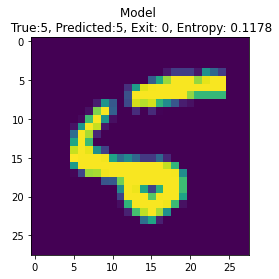

In [ ]:
# Change this to test a different image
test_image_index = 8
# test_models(["split_base_model1.tflite", "split_model_exit1.tflite"], test_image_index, model_type="Float")
# test_models(["split_base_model1.tflite", "split_base_model2.tflite", "split_model_exit2.tflite"], test_image_index, model_type="Float")
# test_models(["split_base_model1.tflite", "split_base_model2.tflite", "split_base_model3.tflite"], test_image_index, model_type="Float")
test_models(["model_chunk1.tflite"], test_image_index, model_type="Float")
test_models(["model_chunk1.tflite", "model_chunk2.tflite"], test_image_index, model_type="Float")
test_models(["model_chunk1.tflite", "model_chunk2.tflite", "model_chunk3.tflite"], test_image_index, model_type="Float")

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_models(tflite_files, model_type):
  global test_images
  global test_labels

  # test_image_indices = range(test_images.shape[0])
  test_image_indices = range(0,500)
  predictions, exits, entropies = run_tflite_models(tflite_files, test_image_indices)

  test_image_labels = [test_labels[i] for i in test_image_indices]
  # print(predictions)
  # print(test_image_labels)
  exit_num_selected = [0 for _ in range(max(exits)+1)]
  for exit in exits:
    exit_num_selected[exit] += 1

  accuracy = (np.sum(test_image_labels== predictions) * 100) / len(test_image_indices)

  print(f"entropy model accuracy is {accuracy:.4f}%, (Number of test samples={len(test_image_indices)})")
  # print(f"exits: {exits}")
  print(f"exit_num_selected: {exit_num_selected}")
  # print(f"entropies: {entropies}")
  print(f"avg entropy: {np.mean(entropies):6f}")

In [ ]:
# evaluate_models(["split_base_model1.tflite", "split_model_exit1.tflite"], model_type="Float")
# evaluate_models(["split_base_model1.tflite", "split_base_model2.tflite", "split_model_exit2.tflite"], model_type="Float")
# evaluate_models(["split_base_model1.tflite", "split_base_model2.tflite", "split_base_model3.tflite"], model_type="Float")
evaluate_models(["model_chunk1.tflite"], model_type="Float")
evaluate_models(["model_chunk1.tflite", "model_chunk2.tflite"], model_type="Float")
evaluate_models(["model_chunk1.tflite", "model_chunk2.tflite", "model_chunk3.tflite"], model_type="Float")

100%|██████████| 500/500 [00:00<00:00, 1023.83it/s]


entropy model accuracy is 93.0000%, (Number of test samples=500)
exit_num_selected: [500]
avg entropy: 0.033511


100%|██████████| 500/500 [00:00<00:00, 1019.50it/s]


entropy model accuracy is 93.4000%, (Number of test samples=500)
exit_num_selected: [457, 43]
avg entropy: 0.030207


100%|██████████| 500/500 [00:00<00:00, 1034.04it/s]

entropy model accuracy is 94.0000%, (Number of test samples=500)
exit_num_selected: [457, 12, 31]
avg entropy: 0.028121


# Save .TFLite as C Array

In [ ]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

def save_c_array_to_file(tflite_file_path):
  tflite_binary = open(tflite_file_path, 'rb').read()
  ascii_bytes = convert_to_c_array(tflite_binary)
  c_file = "const unsigned char tf_model[] DATA_ALIGN_ATTRIBUTE = {\n  " + ascii_bytes + "\n};\nconst int tf_model_len = " + str(len(tflite_binary)) + ";"
  # print(c_file)
  print(f"c_array_len: {len(c_file)}")
  # open("model.h", "w").write(c_file)
  open(tflite_file_path.split(".")[0]+".cpp", "w").write(c_file)

# save_c_array_to_file("split_base_model1.tflite")
# save_c_array_to_file("split_model_exit1.tflite")
# save_c_array_to_file("split_base_model2.tflite")
# save_c_array_to_file("split_model_exit2.tflite")
# save_c_array_to_file("split_base_model3.tflite")
save_c_array_to_file("model_chunk1.tflite")
save_c_array_to_file("model_chunk2.tflite")
save_c_array_to_file("model_chunk3.tflite")

c_array_len: 95793
c_array_len: 77243
c_array_len: 198961


Finally, simply download the generated model.h from the Files section in this notebook and include it in your TF Lite Micro C++ code.



## Visualize and check weights

In [ ]:
# Load tflite file with the created pruned model
tflite_file = "model_all.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_file)
interpreter.allocate_tensors()

details = interpreter.get_tensor_details()

# Weights of the dense layer that has been pruned.
# tensor_name = 'structural_pruning_dense/MatMul'
tensor_name = 'exit1/dense'
detail = [x for x in details if tensor_name in x["name"] and "MatMul" in x["name"]]
print(details)

# We need the first layer.
tensor_data = interpreter.tensor(detail[0]["index"])()
print(detail)

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([-1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'model/base_model1/conv2d/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([5], dtype=int32), 'shape_signature': array([5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'model/base_model2/conv2d_2/BiasAdd/ReadVariableOp', 'index': 2, 'shape': array([10], dtype=int32), 'shape_signature': array([10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=f

In [ ]:
print(f"Shape of Dense layer is {tensor_data.shape}")

Shape of Dense layer is (10, 245)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# The value 24 is chosen for convenience.
# width = height = 24
width = 24
height = 10

subset_values_to_display = tensor_data[0:height, 0:width]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(subset_values_to_display) > 0, val_ones, val_zeros)

In [ ]:
def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

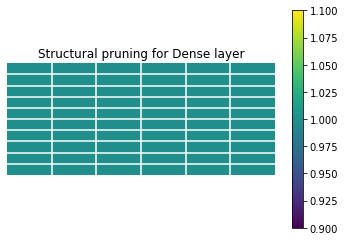

In [ ]:
plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structural pruning for Dense layer")
plt.show()

In [ ]:
# Get weights of the convolutional layer that has been pruned with 2 by 4 sparsity.
# tensor_name = 'structural_pruning/Conv2D'
tensor_name = 'exit1/conv2d'
detail = [x for x in details if tensor_name in x["name"]]
tensor_data = interpreter.tensor(detail[1]["index"])()
print(f"Shape of the weight tensor is {tensor_data.shape}")

Shape of the weight tensor is (5, 3, 3, 5)


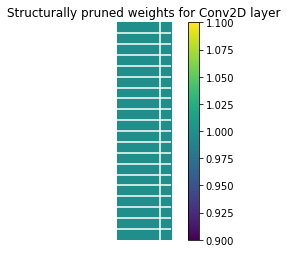

In [ ]:
width = 5
height = 20
weights_to_display = tf.reshape(tensor_data, [tf.reduce_prod(tensor_data.shape[:-1]), -1])
# weights_to_display = weights_to_display[0:width, 0:height]
weights_to_display = weights_to_display[0:height, 0:width]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(weights_to_display) > 1e-9, val_ones, val_zeros)

plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structurally pruned weights for Conv2D layer")
plt.show()